# Анализ картинок

Создайте эмбеддинги изображений и отобразите их в tensorboard projector'е

1. Скачайте датасет [CelebA](https://pytorch.org/vision/stable/datasets.html#celeba) или любой другой не рассмотренный на лекции
1. Выберите одну из предобученных [моделей torchvision](https://pytorch.org/vision/stable/models.html)
1. Создайте эмбеддинги изображений из датасета
1. Визуализируйте эмбеддинги в tensorboard projector

In [1]:
from platform import python_version
import cv2
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import os

%matplotlib inline

In [2]:
prefix = './archive'

In [3]:
df = pd.read_excel(prefix + '/Waifus.xlsx')
df.head(5)

,Kundere,Tsundere,Yandere,Deredere,Dandere,Himedere,Yanguire
0,Rei Ayanami,Minatsu Shiina,Mizuki Himeji,Chiyo Sakura,Hinata Hyuga,Erina Nakiri,Kouha Ren
1,Mei Misaki,Aya Komichi,Konishi,Rinko Yamato,Sekiya Naru,Sena Kashiwazaki,Kureo Mado
2,Eucliwood Hellscythe,Michiru Kinushima,Kurenai Rin,Hotaru Ichijo,Tomoko Kuroki,Lilith Bristol,Akiko Yosano
3,Mashiro Shiina,Misato Tachibana,Belarus,"Kouko ""Roboko"" Kaga",Mio Akiyama,Ayano Kannagi,Seryu Ubiquitous
4,Homura Akemi,Nene Odagiri,Senjogahara Hitagi,"Meiko ""Menma"" Honma",Shiori Shiomiya,Haruhi Suzumiya,Nui Harime


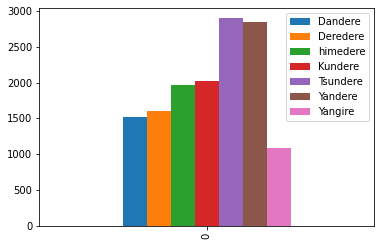

In [4]:
main_path = prefix + '/waifus_images/waifus_images_train'
paths = os.listdir(main_path)
classes = {}
for path in paths:
    classes[path] = [len(os.listdir(os.path.join(main_path, path)))]


df_classes = pd.DataFrame(classes)  
df_classes.plot.bar();

In [5]:
# import tensorflow as tf
import torch
import torchvision.datasets
import torch.nn as nn
from torch.utils.data import DataLoader

In [6]:
train_dir = prefix + '/waifus_images/waifus_images_train'
val_dir = prefix + '/waifus_images/waifus_images_val'
IMG_SIZE = 256
BATCH_SIZE = 32
NUM_CLASSES = len(classes)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(DEVICE)
EPOCH_NUM = 3

cpu


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0


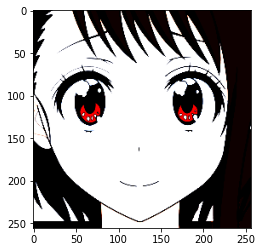

In [7]:
class SmartCrop(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, img):
        # print(img.size)
        cropper = torchvision.transforms.CenterCrop(min(*img.size))
        return cropper.forward(img)
class FillTransp(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, img):
        background = Image.new('RGB', img.size, (255,255,255))
        return Image.alpha_composite(background, img)
transform=torchvision.transforms.Compose(
    [ SmartCrop()
    , torchvision.transforms.Resize((IMG_SIZE, IMG_SIZE))
    # , FillTransp()
    , torchvision.transforms.ToTensor()
    , torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])
train_ds = torchvision.datasets.ImageFolder(train_dir, transform=transform)
val_ds = torchvision.datasets.ImageFolder(val_dir, transform=transform)
# display(train_ds[0][0]) # for PIL
def foo(a):
    print(a[1])
    plt.imshow(a[0].permute(1, 2, 0))
foo(train_ds[0])

dataloaders = {
    'train': DataLoader(
        dataset=train_ds,
        batch_size=128, 
        shuffle=True
    ),
    'val': DataLoader(
        dataset=val_ds,
        batch_size=128, 
        shuffle=True
    )
}

In [8]:
from torchvision.models import resnet50
# Так как мы хотим использовать все фишки библиотеки Pytorch важно наследоваться от nn.Module
class MyClassifier(nn.Module):
    def __init__(self, ouput_dim):
        super(MyClassifier, self).__init__()  # "Регистрируем" создаваемый объект как нейросетевую модель
        self.model = resnet50(pretrained=True)  # Скачиваем пред-обученную основу для нашей модели
        
        # "Замораживаем" все веса для ускорения обучения (мы считаем что они уже хорошо обучены)
        for param in self.model.parameters():
            param.requires_grad = False
        
        # Создаем "голову" которую мы и будем обучать
        self.fc1 = nn.Sequential(
            nn.Linear(1000, 64),
            nn.ReLU()
        )
        self.fc2 = nn.Sequential(
            nn.Dropout(0.25),
            nn.Linear(64, ouput_dim)
        )
    
    def embed(self, x):
        return self.fc1(self.model(x))
    
    # Описываем как именно наша модель будет генерировать предсказания
    def forward(self, x):
        resnet_out = self.embed(x)
        return self.fc2(resnet_out)

In [9]:
model = MyClassifier(NUM_CLASSES)
model = model.to(DEVICE)

In [10]:
# Создаем функцию ошибки (так как задача многоклассовой классификации, то используем кросс-энтропию)
# Более подробно об этом будет в курсе машинного обучения
loss_function = torch.nn.CrossEntropyLoss()

# Регистрируем для нашей модели способ изменения её весов
optimizer = torch.optim.Adam(model.parameters(), amsgrad=True, lr=1e-4)

In [11]:
from tqdm.notebook import tqdm, trange
loss_hist = {'train': [], 'val': []}
acc_hist = {'train': [], 'val': []}

# Важно! В данном примере точность используется для упрощения.
# Никогда не используйте её если у вас несбалансированная выборка
# Возьмите лучше F_score или ROC_AUC (об этом вам потом расскажут)

# Основной алгоритм обучения
for epoch in trange(EPOCH_NUM, desc='Whole pipeline'):
    
    for phase in ['train', 'val']:
        dataloader = dataloaders[phase]
        
        # Это условие необходимо так как у нас есть слой DropOut
        # И на валидации его принято фиксировать
        if phase == 'train':
            model.train() 
        elif phase == 'val':
            model.eval()
        
        running_loss = 0.
        running_acc = 0.
        
        # Проходимся по набору данных
        for (X_batch, y_batch) in tqdm(dataloader, desc=f'Epoch: {epoch + 1}. Phase: {phase}'):
            # Нормализуем наши данные
            # X_batch = X_batch / 255
            # X_batch = torchvision.transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(X_batch)
            
            # Переносим на устройство
            X_batch = X_batch.to(DEVICE)
            y_batch = y_batch.to(DEVICE)
            
            # Для корректного обучения перед каждым шагом необходимо сбрасывать прошлые ошибки
            optimizer.zero_grad()
            
            with torch.set_grad_enabled(phase == 'train'):
                y_pred = model(X_batch)
                
                loss_value = loss_function(y_pred, y_batch)
                y_pred_class = y_pred.argmax(dim=1)
                
                # На обучении мы хотим учиться в зависимости от ошибки
                if phase == 'train':
                    loss_value.backward()
                    optimizer.step()
       
            # Аггрегируем ошибку и точность
            running_loss += loss_value.item()
            running_acc += (y_pred_class == y_batch.data).float().mean().data.cpu().numpy()
        
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)
        
        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} ', end='')
        
        loss_hist[phase].append(epoch_loss)
        acc_hist[phase].append(epoch_acc)

Whole pipeline:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 1. Phase: train:   0%|          | 0/109 [00:00<?, ?it/s]

x:\python39\lib\site-packages\PIL\Image.py:973: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


train Loss: 1.8524 Acc: 0.2504 

Epoch: 1. Phase: val:   0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 1.7921 Acc: 0.2630 

Epoch: 2. Phase: train:   0%|          | 0/109 [00:00<?, ?it/s]

train Loss: 1.7301 Acc: 0.3168 

Epoch: 2. Phase: val:   0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 1.7003 Acc: 0.3094 

Epoch: 3. Phase: train:   0%|          | 0/109 [00:00<?, ?it/s]

train Loss: 1.6615 Acc: 0.3553 

Epoch: 3. Phase: val:   0%|          | 0/21 [00:00<?, ?it/s]

val Loss: 1.6566 Acc: 0.3310 

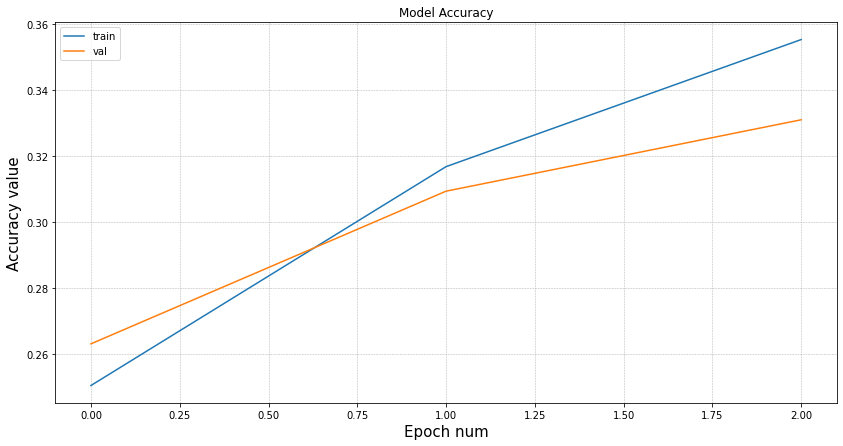

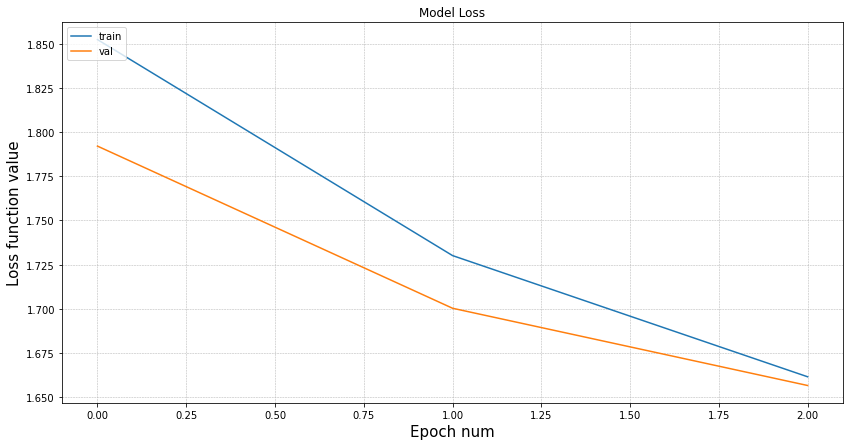

In [12]:
plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in acc_hist.keys():
    plt.plot(acc_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Accuracy')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Accuracy value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

plt.rcParams['figure.figsize'] = (14, 7)
for experiment_id in loss_hist.keys():
    plt.plot(loss_hist[experiment_id], label=experiment_id)
plt.legend(loc='upper left')
plt.title('Model Loss')
plt.xlabel('Epoch num', fontsize=15)
plt.ylabel('Loss function value', fontsize=15)
plt.grid(linestyle='--', linewidth=0.5, color='.7')
plt.show()

In [13]:
# lena = transform(Image.open(prefix + '/truelena.png'))
# plt.imshow(lena.permute(1, 2, 0));

In [14]:
import random
train_items = [train_ds[random.randint(0, len(train_ds))] for i in range(300)]
xs, ys = zip(*train_items)

xs = torch.stack(xs)
# xs = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(xs)
xs.size()

torch.Size([300, 3, 256, 256])

In [15]:
embs = model.embed(xs)
embs.size()

torch.Size([300, 64])

In [16]:
import umap

In [17]:
points = umap.UMAP().fit_transform(embs.detach().numpy());

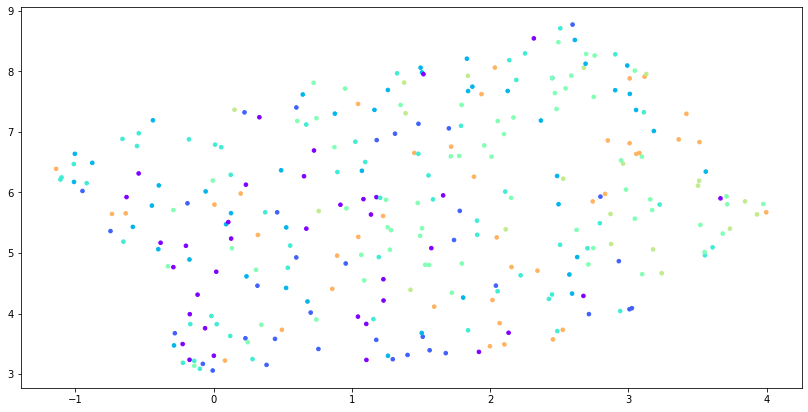

In [18]:
import matplotlib.colors
cmap = plt.cm.rainbow
norm = matplotlib.colors.Normalize(vmin=0, vmax=8)
plt.scatter(points[:, 0], points[:, 1], s=13, c=cmap(norm(ys)));

In [19]:
xs.size()

torch.Size([300, 3, 256, 256])

In [20]:
from tensorboardX import SummaryWriter

In [21]:
with SummaryWriter() as writer:
    # features = xs.mean(dim=1).view(-1, IMG_SIZE * IMG_SIZE)
    writer.add_embedding( embs
                        , metadata=ys
                        , label_img=xs
                        )

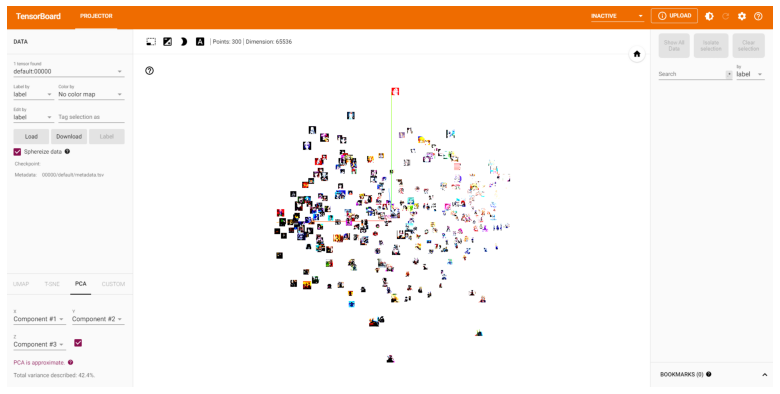

In [22]:
plt.imshow(cv2.cvtColor(cv2.imread('archive/proj.png'), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

http://localhost:6006/

Видно что они отсортировались просто по насыщенности изображения, что действительно может позволить предсказывать с вероятностью 35%: "злые" типы, скорее всего, имеют более темную гамму на картинках

# Лена

Примените фильтр к изображению Лены

1. Скачайте изображение [Лены](http://optipng.sourceforge.net/pngtech/img/lena.png)
1. Найдите фильтр для выделения признака на изображении. В лекции показан пример фильтра Собеля. Использовать примеры с лекций нельзя. Начать поиск фильтра можно с [этой страницы](https://en.wikipedia.org/wiki/Feature_(computer_vision)#Extraction)
1. Реализуйте процедуру свёртки изображения с фильтром
1. Сверните Лену

In [23]:
!curl http://optipng.sourceforge.net/pngtech/img/lena.png --output archive/lena.png

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  1  462k    1  5474    0     0   5474      0  0:01:26 --:--:--  0:01:26 11286
 75  462k   75  347k    0     0   347k      0  0:00:01  0:00:01 --:--:--  258k
100  462k  100  462k    0     0   462k      0  0:00:01  0:00:01 --:--:--  344k


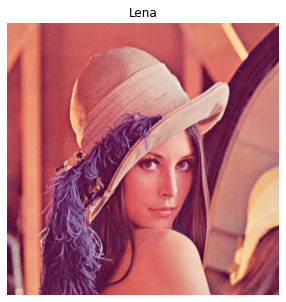

In [24]:
img = cv2.cvtColor(cv2.imread('archive/lena.png'), cv2.COLOR_BGR2RGB)

plt.figure(figsize=(15, 5))
plt.title('Lena')
plt.imshow(img)
plt.axis('off')
plt.show()

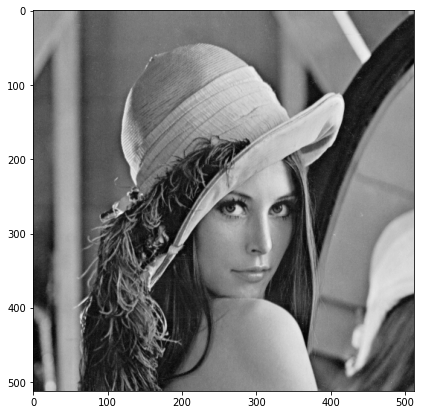

In [25]:
imgg = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(imgg, cmap='gray')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


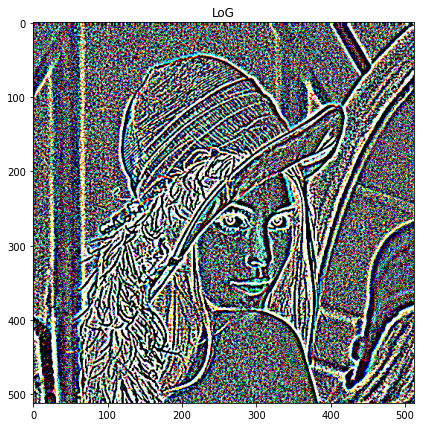

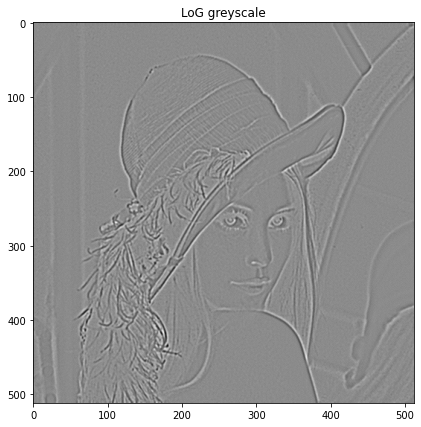

In [26]:
plt.imshow(cv2.Laplacian(cv2.GaussianBlur(img, (5, 5), 0), cv2.CV_64F))
plt.title('LoG')
plt.show()
plt.imshow(cv2.Laplacian(cv2.GaussianBlur(imgg, (5, 5), 0), cv2.CV_64F), cmap='gray')
plt.title('LoG greyscale')
plt.show()

In [27]:
from scipy.signal import convolve2d
"""
convolve2dOld = convolve2d
def convolve2d(*args, **kwargs):
    return convolve2dOld(*args, **kwargs), boundary='symm')
"""
# https://en.wikipedia.org/wiki/Kernel_(image_processing)
def myConvolve2d(image, filt):
    ishp = image.shape
    fshp = filt.shape
    dshp = np.array(ishp) - np.array(fshp)
    filt = filt
    return np.array(
        [ [ np.sum( image[i : i+fshp[0], j : j+fshp[1]] * filt
                  , axis=(0, 1)
                  )
            for j in range(dshp[1])
          ] for i in range(dshp[0])
        ]
    )

In [28]:
def gaussian_filter(r, sigma):
    sigma2m2 = sigma ** 2 * 2
    return np.array(
        [ [ np.exp(-(x**2 + y**2)  / sigma2m2) / (np.pi * sigma2m2)
            for x in range(-r, r + 1)
          ] for y in range(-r, r + 1)
        ]
    )

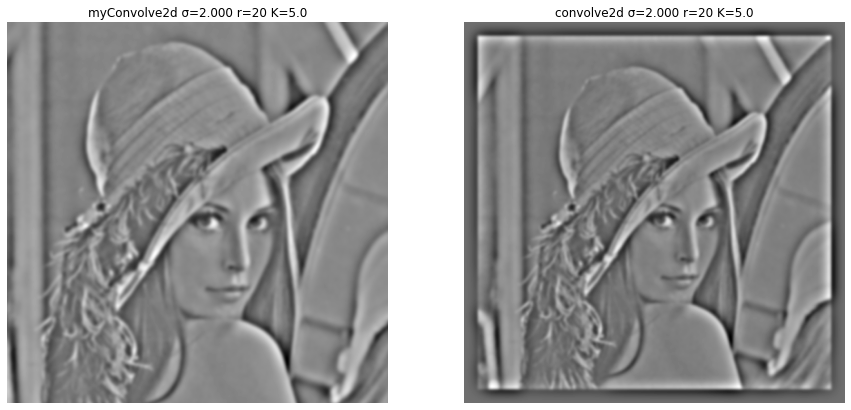

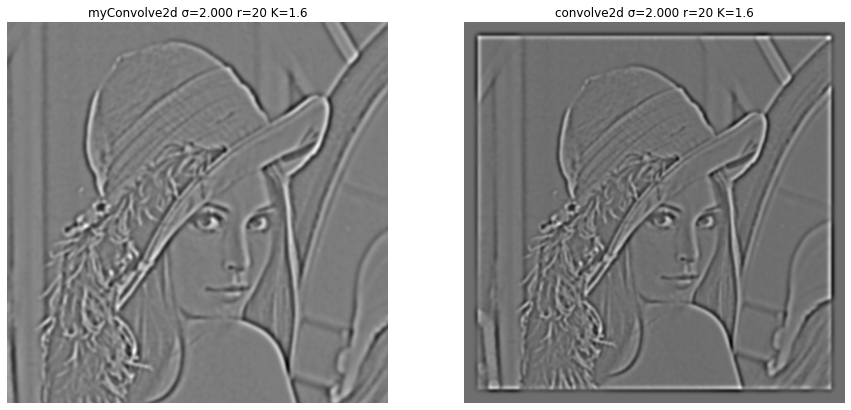

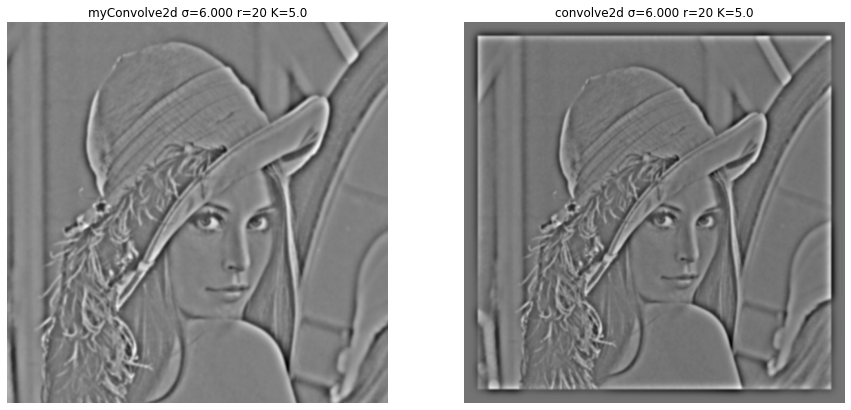

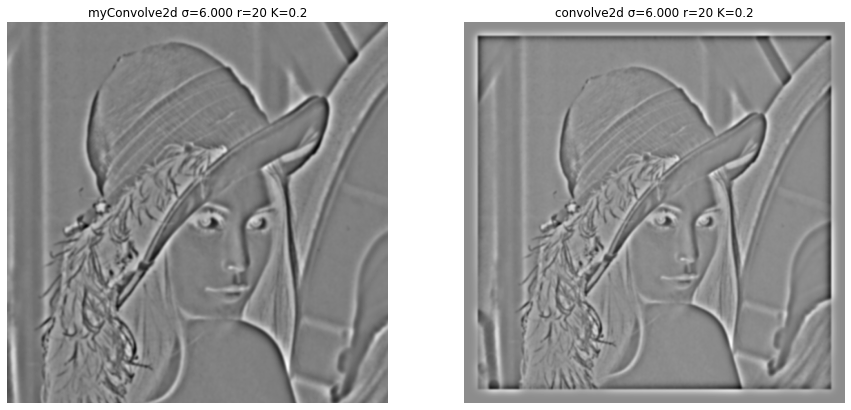

In [29]:
# https://en.wikipedia.org/wiki/Difference_of_Gaussians
def makeImgConv(i, conv, r, sigma, K=1, K2=1):
    convolved = conv(imgg, gaussian_filter(r, sigma * K2) - gaussian_filter(r, sigma * K))
    ax = plt.subplot(1, 2, i)
    ax.imshow(convolved, cmap='gray')
    ax.set_title(conv.__name__ + ' σ=%.3f' % sigma + ' r=' + str(r) + ' K=' + str(K / K2))
    ax.axis('off')
def makeImg(*args, **kwargs):
    plt.figure(figsize=(15, 10))
    makeImgConv(1, myConvolve2d, *args, **kwargs)
    makeImgConv(2, convolve2d, *args, **kwargs)
    plt.show()
sigma = 2
r = 20
makeImg(r, sigma, 5)
makeImg(r, sigma, 1.6)
sigma = 6
makeImg(r, sigma, K2=1/5)
makeImg(r, sigma, K=1/5)

мой Convolve вычитает `shape` фильтра $\Rightarrow$ нет рамки